# Performing 10-fold cross validation and parameter tuning on the CUSUM algorithm*

### * This code belongs to the paper "Early Prediction of End Stage Kidney Disease Based on Cumulative Estimated Glomerular Filtration Rate Velocity"

In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import time
import pandas as pd
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql.window import Window
import socket    
hostname = socket.gethostname()    
IPAddr = socket.gethostbyname(hostname)  

#conf = SparkConf()
conf = SparkConf().setAll([("spark.executor.instances", '5'), ('spark.executor.memory', '8g'), ('spark.executor.cores', '5'), ('spark.driver.memory','3g'),('spark.sql.broadcastTimeout', '3000')])
conf.setMaster('yarn')
conf.setAppName('spark-yarn-2')
#conf.set("spark.driver.host", '10.42.7.162') #Change it accordingly based on your host ip 
#address. Open a terminal and use "cat /etc/hosts", the last line is the host ip and the host name.
conf.set("spark.driver.host", IPAddr)#Change it accordingly based on your host ip address

## Preparing the datapool

In [ ]:
datapool_ESRD = pd.read_csv('Final_ESRD_group_done_pandas.csv')
datapool_ESRD = datapool_ESRD.drop(columns=datapool_ESRD.columns[0])
datapool_control = pd.read_csv("Final_Normal_group_done_pandas.csv")
datapool_control = datapool_control.drop(columns=datapool_control.columns[0])

datapool_control = datapool_control.drop(datapool_control.index[np.isinf(datapool_control.eGFR_EPI) == True], axis = 0)
#Pulling out each patient's data 
#Also. sortinh the data by cSr lavel measurement data and reindexing it

patients_list_Normal = list(set(np.unique(list(datapool_control['patient_sk']))))
patients_list_ESRD = list(set(np.unique(list(datapool_ESRD['patient_sk']))))

# !!!! SHOULD TURN TO TOTAL_SECONDS IN THE MIDST OF ALGORITHM

datapool_control['Date'] = pd.to_datetime(datapool_control['Date'])
datapool_control['Date'] = pd.to_datetime(datapool_control['Date'])
datapool_control_dates = datapool_control.groupby('patient_sk').agg({'Date': 'min'})
datapool_control_dates = datapool_control_dates.reset_index()
datapool_control = datapool_control.merge(datapool_control_dates, on = 'patient_sk', how='left')
datapool_control['Date_seconds'] = (datapool_control['Date_x'] - datapool_control['Date_y'])
datapool_control = datapool_control.rename({'Date_x':'Date'}, axis = 1)
datapool_control = datapool_control.drop('Date_y', axis = 1)
datapool_control['Date_seconds'] = datapool_control['Date_seconds'].dt.total_seconds()

datapool_ESRD['Date'] = pd.to_datetime(datapool_ESRD['Date'])
datapool_ESRD['Date'] = pd.to_datetime(datapool_ESRD['Date'])
datapool_ESRD_dates = datapool_ESRD.groupby('patient_sk').agg({'Date': 'min'})
datapool_ESRD_dates = datapool_ESRD_dates.reset_index()
datapool_ESRD = datapool_ESRD.merge(datapool_ESRD_dates, on = 'patient_sk', how='left')
datapool_ESRD['Date_seconds'] = datapool_ESRD['Date_x'] - datapool_ESRD['Date_y']
datapool_ESRD = datapool_ESRD.rename({'Date_x':'Date'}, axis = 1)
datapool_ESRD = datapool_ESRD.drop('Date_y', axis = 1)
datapool_ESRD['Date_seconds'] = datapool_ESRD['Date_seconds'].dt.total_seconds()

#Getting rid of Normal min eGFR < 60

datapool_control_patients = datapool_control.groupby('patient_sk').agg({'eGFR_EPI': 'min'})
datapool_control_patients = datapool_control_patients[datapool_control_patients['eGFR_EPI']>=60]
datapool_control_patients = datapool_control_patients.reset_index()

datapool_control = datapool_control_patients.merge(datapool_control, on = 'patient_sk', how = 'inner')
datapool_control = datapool_control.rename({'eGFR_EPI_y':'eGFR_EPI'}, axis = 1)
datapool_control = datapool_control.drop('eGFR_EPI_x', axis = 1)

patients_list_control_above_50 = list(set(np.unique(list(datapool_control['patient_sk']))))

patients_list_Normal = patients_list_control_above_60



#Getting rid of ESRD min eGFR < 60

datapool_ESRD_patients = datapool_ESRD.groupby('patient_sk').agg({'Date': 'min'})
datapool_ESRD_patients = datapool_ESRD_patients.reset_index()

datapool_ESRD_patients_eGFR = datapool_ESRD.merge(datapool_ESRD_patients, on=['patient_sk', 'Date'], how ='inner')
datapool_ESRD_patients_eGFR = datapool_ESRD_patients_eGFR.drop_duplicates('patient_sk')
datapool_ESRD_patients_eGFR = datapool_ESRD_patients_eGFR[datapool_ESRD_patients_eGFR['eGFR_EPI']>=60]

datapool_ESRD_new = datapool_ESRD.merge(datapool_ESRD_patients_eGFR['patient_sk'], on = 'patient_sk', how = 'inner')

datapool_ESRD = datapool_ESRD_new
datapool_ESRD = datapool_ESRD.drop_duplicates()
patients_list_ESRD = list(set(np.unique(list(datapool_ESRD['patient_sk']))))

all_patients = patients_list_Normal + patients_list_ESRD

print(len(patients_list_Normal))
print(len(patients_list_ESRD))
print(len(all_patients))

## Test Vs. Training sets (0.2 test, 0.8 training)

In [ ]:
# Sampling form the Entire Datapool

import random
Test_all_patients = random.sample(all_patients, k = 18790)

#Re-creating the control and ESRD sets

Test_Normal_patients = pd.DataFrame({'patient_sk':list(set(patients_list_Normal).intersection(Test_all_patients))})
Testset_control = Test_Normal_patients.merge(datapool_control, on = 'patient_sk', how = 'inner')

Test_ESRD_patients = pd.DataFrame({'patient_sk':list(set(patients_list_ESRD).intersection(Test_all_patients))})
Testset_ESRD = Test_ESRD_patients.merge(datapool_ESRD, on = 'patient_sk', how = 'inner')

Training_Normal_patients = pd.DataFrame({'patient_sk':list(set(patients_list_Normal).difference(Test_all_patients))})
Trainingset_control = Training_Normal_patients.merge(datapool_control, on = 'patient_sk', how = 'inner')

Training_ESRD_patients = pd.DataFrame({'patient_sk':list(set(patients_list_ESRD).difference(Test_all_patients))})
Trainingset_ESRD = Training_ESRD_patients.merge(datapool_ESRD, on = 'patient_sk', how = 'inner')

print('Training: ', Training_Normal_patients.shape[0], Training_ESRD_patients.shape[0])
print('Test:     ', Test_Normal_patients.shape[0], Test_ESRD_patients.shape[0])

In [ ]:
Testset_control.to_csv('Testset_control.csv')
Testset_ESRD.to_csv('Testset_ESRD.csv')
Trainingset_control.to_csv('Trainingset_control.csv')
Trainingset_ESRD.to_csv('Trainingset_ESRD.csv')

In [ ]:
Testset_control = pd.read_csv('Testset_control.csv')
Testset_ESRD = pd.read_csv('Testset_ESRD.csv')
Trainingset_control = pd.read_csv('Trainingset_control.csv')
Trainingset_ESRD = pd.read_csv('Trainingset_ESRD.csv')

In [ ]:
Training_Normal_patients = pd.DataFrame({'patient_sk':list(Trainingset_control.patient_sk.unique())})
Training_ESRD_patients = pd.DataFrame({'patient_sk':list(Trainingset_ESRD.patient_sk.unique())})

### And The Oscar goes to:

In [ ]:
#10 folds, 1 time  (1*1*1), ~33 seconds
#10 folds, 8 times (2*2*2), ~220 seconds , second try = 177 seconds! , third try = 167 seconds!!! , forth: 161 !!!(-> linearly speaking it should be 264 seconds)
#10 folds, 9,261 times (7*21*15), ~220 seconds -> linearly speaking it should be 2,205 seconds

import random
from numba import jit
from IPython.display import display, HTML

start = time.time()

V0_list = [-10]
w_list = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
T_list = [0, -0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4.0, -4.5, -5.0, -5.5, -6.0, -6.5, -7.0, -7.5, -8.0, -8.5, -9, -9.5, -10]
#a_list = np.linspace(0.0, 1.0,  num = 21)
a = 0.2

k_folds = 10

Mu_list = []
Sigma_list = []
            
sampled_measurements = pd.DataFrame({}, index = [])
        
for i in range(k_folds):
    
    sampled_Normal_patients = random.sample(list(Training_Normal_patients.patient_sk), k = Training_ESRD_patients.shape[0])
#    sampled_Normal_patients = pd.DataFrame({'patient_sk':list(set(patients_list_Normal).intersection(sampled_Normal_patients))})
    sampled_Normal_patients = pd.DataFrame({'patient_sk':sampled_Normal_patients})
    Trainingset_control_sampled = sampled_Normal_patients.merge(Trainingset_control, on = 'patient_sk', how = 'inner')
    
    
    #Sampled Mu and sigma

    var_list = []
    n_list = []

    mu = np.mean(Trainingset_control_sampled['eGFR_EPI'])

    var_list = Trainingset_control_sampled.groupby('patient_sk').agg({'eGFR_EPI':'std'})
    var_list = list(var_list.eGFR_EPI)

    n_list =  Trainingset_control_sampled.groupby('patient_sk').agg({'patient_sk':'count'})
    n_list = list(n_list.patient_sk)
    #calculating the mean and variance of the Normal sample

    n_1 = list((n_list - np.ones(len(n_list))).astype('int'))
    numerator = np.multiply(n_1, np.power(var_list, 2))
    denominator = sum(n_list) - len(n_list)
    sigma = np.power(sum(numerator)/denominator,0.5)

    
    Mu_list.append(mu)
    Sigma_list.append(sigma)
    
    
    Accuracy_list = []
    Sensetivity_list = []
    Specificity_list = []
 

    for V0 in V0_list:
        for w in w_list:
            for T in T_list:
                
                datapool_control = Trainingset_control_sampled
                datapool_ESRD = Trainingset_ESRD
    ## Zi:
                datapool_control['Zi'] = (datapool_control.eGFR_EPI - mu)/sigma
                datapool_ESRD['Zi'] = (datapool_ESRD.eGFR_EPI - mu)/sigma

    ## AAANNNDDD let us start palying with Zi and Vi :) AND THE SLOPES AS WELL :)

                @jit(nopython=True)
                def Vi_creator(Zi, patient_sk):
                    Vi = np.zeros(Zi.shape)
                    Vi[0] = V0

                    for i in range(1, Vi.shape[0]):
                        if patient_sk[i] == patient_sk[i-1]:
                            Vi[i] = (min(0.0, Zi[i] + w + Vi[i-1]))
                        else:
                            Vi[i] = V0

                    return Vi

                datapool_control['Vi'] = Vi_creator(datapool_control['Zi'].values, datapool_control['patient_sk'].values)
                datapool_ESRD['Vi'] = Vi_creator(datapool_ESRD['Zi'].values, datapool_ESRD['patient_sk'].values)

    ### OMG! The Slopes!

                Inst_slope_initial = 0.0
                Smooth_slope_initial = 0.0

                @jit(nopython=True)
                def Slope_creator(Vi, patient_sk, Date_seconds, eGFR_EPI):
                    Inst_slope = np.zeros(Vi.shape)
                    Smooth_slope = np.zeros(Vi.shape)

                    Inst_slope[0] = Inst_slope_initial
                    Smooth_slope[0] = Smooth_slope_initial

                    for i in range(1, Vi.shape[0]):
                        if patient_sk[i] == patient_sk[i-1]:
                            if Vi[i-1] == 0.0 :
                                if Date_seconds[i] - Date_seconds[i-1] != 0:
                                    Inst_slope[i] = min(0.0, (eGFR_EPI[i] - mu)/((Date_seconds[i] - Date_seconds[i-1])/86400))
                                else:
                                    Inst_slope[i] = Inst_slope[i-1]
                            else:
                                if Date_seconds[i] - Date_seconds[i-1] != 0:
                                    Inst_slope[i] = min(0.0, (eGFR_EPI[i] - eGFR_EPI[i-1])/((Date_seconds[i] - Date_seconds[i-1])/86400))
                                else:
                                    Inst_slope[i] = Inst_slope[i-1]
                            if Date_seconds[i] - Date_seconds[i-1] != 0:
                                Smooth_slope[i] = (1-a) * Smooth_slope[i-1] + a * (min(0.0, (eGFR_EPI[i] - eGFR_EPI[i-1])/((Date_seconds[i] - Date_seconds[i-1])/86400)))
                            else:
                                Smooth_slope[i] = Smooth_slope[i-1]
                        else:
                            Inst_slope[i] = Inst_slope_initial
                            Smooth_slope[i] = Smooth_slope_initial

                    return [Inst_slope, Smooth_slope]

                [datapool_control['Inst_slope'],datapool_control['Smooth_slope']] = Slope_creator(datapool_control['Vi'].values, datapool_control['patient_sk'].values, datapool_control['Date_seconds'].values, datapool_control['eGFR_EPI'].values)
                [datapool_ESRD['Inst_slope'], datapool_ESRD['Smooth_slope']] = Slope_creator(datapool_ESRD['Vi'].values, datapool_ESRD['patient_sk'].values, datapool_ESRD['Date_seconds'].values, datapool_ESRD['eGFR_EPI'].values)


    # Making up the result trigger date and eGFR tables

                patients_control_trigger = datapool_control[datapool_control['Vi'] <= T].groupby('patient_sk').agg({'Date': 'min'})
                patients_control_trigger = patients_control_trigger.reset_index()
                patients_control_trigger = patients_control_trigger.merge(datapool_control[['patient_sk', 'eGFR_EPI', 'Date']], on=['patient_sk', 'Date'], how='inner')
                patients_control_trigger = patients_control_trigger.drop_duplicates('patient_sk')
                patients_control_trigger['New_label'] = list(np.ones(len(patients_control_trigger)))

                patients_ESRD_trigger = datapool_ESRD[datapool_ESRD['Vi'] <= T].groupby('patient_sk').agg({'Date': 'min'})
                patients_ESRD_trigger = patients_ESRD_trigger.reset_index()
                patients_ESRD_trigger = patients_ESRD_trigger.merge(datapool_ESRD[['patient_sk', 'eGFR_EPI', 'Date']], on=['patient_sk', 'Date'], how='inner')
                patients_ESRD_trigger = patients_ESRD_trigger.drop_duplicates('patient_sk')
                patients_ESRD_trigger['New_label'] = list(np.ones(len(patients_ESRD_trigger)))


    #Labeling and finishing :)

                patients_Normal_labeled = pd.DataFrame({'patient_sk' : list(sampled_Normal_patients.patient_sk) , 'Label' : list(np.zeros(len(sampled_Normal_patients)))})
                patients_Normal_labeled = patients_Normal_labeled.merge(patients_control_trigger, on='patient_sk', how='left')

                patients_ESRD_labeled = pd.DataFrame({'patient_sk' : list(Training_ESRD_patients.patient_sk) , 'Label' : list(np.ones(len(Training_ESRD_patients)))})
                patients_ESRD_labeled = patients_ESRD_labeled.merge(patients_ESRD_trigger, on='patient_sk', how='left')


    #Accuracy, Sensetivity, Specificity
                # ESRD NaN = 0.0
                # Normal NaN = 0.0

                #RIGHT detection in ESRD:
                numbet_of_ones_ESRD = patients_ESRD_labeled[patients_ESRD_labeled['New_label'] == 1].shape[0]

                #WRONG detection in Normal
                numbet_of_ones_Normal = patients_Normal_labeled[patients_Normal_labeled['New_label'] == 1].shape[0]

                total_ESRD = patients_ESRD_labeled.shape[0]
                total_Normal = patients_Normal_labeled.shape[0]


                # Accuracy
                Accuracy = (numbet_of_ones_ESRD + (total_Normal - numbet_of_ones_Normal))/(total_ESRD + total_Normal)

                #Sensetivity
                tp = numbet_of_ones_ESRD
                fn = total_ESRD - numbet_of_ones_ESRD
                Sensetivity = tp/(tp+fn)

                #Specificity
                tn = total_Normal - numbet_of_ones_Normal
                fp = numbet_of_ones_Normal
                Specificity = tn/(tn+fp)

                Accuracy_list.append(Accuracy)
                Sensetivity_list.append(Sensetivity)
                Specificity_list.append(Specificity)
                
                
    sampled_measurements['Accuracy_fold_{}'.format(i)] = Accuracy_list
    sampled_measurements['Sensetivity_fold_{}'.format(i)] = Sensetivity_list
    sampled_measurements['Specificity_fold_{}'.format(i)] = Specificity_list
    
end = time.time()
print(end - start)

In [ ]:
combinations = []
combination_list = []
for V0 in V0_list:
    for w in w_list:
        for T in T_list:
            a = 'V0={}, w={}, T={}'.format(V0, w, T)
            combinations.append(a)
            combination_list.append([V0, w, T])

In [ ]:
sampled_measurements['Combinations'] = combinations
sampled_measurements.set_index('Combinations')

In [ ]:
sampled_measurements.to_csv('sampled_measurements_v0_neg_10.csv')

In [ ]:
Mean_Accuracy = np.array([list(np.zeros(sampled_measurements.shape[0]))])
Mean_Sensetivity = np.array([list(np.zeros(sampled_measurements.shape[0]))])
Mean_Specificity = np.array([list(np.zeros(sampled_measurements.shape[0]))])
for i in range(10):
    
    Mean_Accuracy = Mean_Accuracy + np.array(list(sampled_measurements['Accuracy_fold_{}'.format(i)]))/((sampled_measurements.shape[1] - 1)/3)
    Mean_Sensetivity = Mean_Sensetivity + np.array(list(sampled_measurements['Sensetivity_fold_{}'.format(i)]))/((sampled_measurements.shape[1] - 1)/3)
    Mean_Specificity = Mean_Specificity + np.array(list(sampled_measurements['Specificity_fold_{}'.format(i)]))/((sampled_measurements.shape[1] - 1)/3)

In [ ]:
Combination_wise_table = pd.DataFrame({'Combinations' : list(combinations) , 'Mean_Accuracy' : list(Mean_Accuracy[0]) , 'Mean_Sensetivity' : list(Mean_Sensetivity[0]) , 'Mean_Specificity' : list(Mean_Specificity[0])})

In [ ]:
Combination_wise_table.to_csv('Combination_wise_table_v0_neg_10.csv')

In [ ]:
Combination_wise_table[Combination_wise_table.Mean_Specificity == np.max(Combination_wise_table.Mean_Specificity)]

In [ ]:
## ROC curve (Receiver Operating Characteristic)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,8))

i = 0


    
Sensetivity_list = list(Combination_wise_table['Mean_Sensetivity'])
Specificity_list = list(Combination_wise_table['Mean_Specificity'])
Accuracy_list = list(Combination_wise_table['Mean_Accuracy'])

max_accuracy = max(Accuracy_list)
max_index = Accuracy_list.index(max_accuracy)
comcom = combinations[max_index]

FPR = list(np.ones(len(Specificity_list)) - Specificity_list)

ax.plot(list(FPR), Sensetivity_list, color="orchid", lw=2, ls='-', marker='o', markersize=8, markerfacecolor="purple")

ax.set_xlabel('FPR = 1 - Specificity')
ax.set_ylabel('TPR = Sensetivity')

ax.set_title('Max Accuracy = {}, with {}'.format(max_accuracy, comcom))

i = 0

ax.set_ylim([0,1])
ax.set_xlim([0,1])

for label, x, y in zip(Combination_wise_table['Combinations'], list(FPR), Sensetivity_list):
    ax.annotate(
        label,
        xy=(x, y), xytext=(-15, 15),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))        


In [ ]:
accuracy_data_sampling = pd.DataFrame({'[V0, w, T]':combination_list,'Sample No. 0' : Accuracy_FULL[0], 'Sample No. 1' : Accuracy_FULL[1], 'Sample No. 2' : Accuracy_FULL[2], 'Sample No. 3' : Accuracy_FULL[3], 'Sample No. 4' : Accuracy_FULL[4], 'Sample No. 5' : Accuracy_FULL[5], 'Sample No. 6' : Accuracy_FULL[6], 'Sample No. 7' : Accuracy_FULL[7], 'Sample No. 8' : Accuracy_FULL[8], 'Sample No. 9' : Accuracy_FULL[9]})

In [ ]:
sensetivity_data_sampling = pd.DataFrame({'[V0, w, T]':combination_list, 'Sample No. 0' : Sensetivity_FULL[0], 'Sample No. 1' : Sensetivity_FULL[1], 'Sample No. 2' : Sensetivity_FULL[2], 'Sample No. 3' : Sensetivity_FULL[3], 'Sample No. 4' : Sensetivity_FULL[4], 'Sample No. 5' : Sensetivity_FULL[5], 'Sample No. 6' : Sensetivity_FULL[6], 'Sample No. 7' : Sensetivity_FULL[7], 'Sample No. 8' : Sensetivity_FULL[8], 'Sample No. 9' : Sensetivity_FULL[9]})

In [ ]:
specificity_data_sampling = pd.DataFrame({'[V0, w, T]':combination_list, 'Sample No. 0' : Specificity_FULL[0], 'Sample No. 1' : Specificity_FULL[1], 'Sample No. 2' : Specificity_FULL[2], 'Sample No. 3' : Specificity_FULL[3], 'Sample No. 4' : Specificity_FULL[4], 'Sample No. 5' : Specificity_FULL[5], 'Sample No. 6' : Specificity_FULL[6], 'Sample No. 7' : Specificity_FULL[7], 'Sample No. 8' : Specificity_FULL[8], 'Sample No. 9' : Sensetivity_FULL[9]})

In [ ]:
sampling_initial_data = pd.DataFrame({'Mu"s' : mu_sampled, 'Sigma"s' :sigma_sampled, 'Samples':patient_sampled_total})

In [ ]:
patient_sampled = []
patient_sampled_total = []
for dataaa_control in dataaa_control_sampled:
    for patient in dataaa_control:    
        patient_sampled.append(patient['patient_sk'][0])
        
    patient_sampled_total.append(patient_sampled)

In [ ]:
#accuracy_data_sampling.to_csv('accuracy_data_sampling_pandas.csv')
#sensetivity_data_sampling.to_csv('sensetivity_data_sampling_pandas.csv')
#specificity_data_sampling.to_csv('specificity_data_sampling_pandas.csv')
#sampling_initial_data.to_csv('mu_and_sigma_sampled_pandas.csv')
sampling_initial_data.to_csv('sampling_initial_data.csv')

### Plot them

In [ ]:
## ROC curve (Receiver Operating Characteristic)

import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=10, ncols=1, figsize = (8,60))

i = 0

for ax in axes:
    
    Specificity_list = Specificity_FULL[i]
    Specificity_list = Specificity_FULL[i]
    Accuracy_list = Accuracy_FULL[i]
    
    max_accuracy = max(Accuracy_list)
    max_index = Accuracy_list.index(max_accuracy)
    comcom = combinations[max_index]
    
    FPR = np.ones(len(Specificity_list)) - Specificity_list

    ax.plot(FPR, Sensetivity_list, color="orchid", lw=2, ls='-', marker='o', markersize=8, markerfacecolor="purple")

    ax.set_xlabel('FPR = 1 - Specificity')
    ax.set_ylabel('TPR = Sensetivity')
    
    ax.set_title('Max Accuracy = {}, with {}'.format(max_accuracy, comcom))
    
    i = 0
    
    #ax.set_ylim([0,1])
    #ax.set_xlim([0,1])
    
    for label, x, y in zip(combinations, FPR, Sensetivity_list):
        ax.annotate(
            label,
            xy=(x, y), xytext=(-15, 15),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))        


### Plot them! once again

In [ ]:
comb0 = pd.read_csv('Combination_wise_table_v0_0.csv')
comb05 = pd.read_csv('Combination_wise_table_v0_neg_0_5.csv')
comb1 = pd.read_csv('Combination_wise_table_v0_neg_1.csv')
comb15 = pd.read_csv('Combination_wise_table_v0_neg_1_5.csv')
comb2 = pd.read_csv('Combination_wise_table_v0_neg_2.csv')
comb25 = pd.read_csv('Combination_wise_table_v0_neg_2_5.csv')
comb3 = pd.read_csv('Combination_wise_table_v0_neg_3.csv')
comb35 = pd.read_csv('Combination_wise_table_v0_neg_3_5.csv')
comb4 = pd.read_csv('Combination_wise_table_v0_neg_4.csv')
comb45 = pd.read_csv('Combination_wise_table_v0_neg_4_5.csv')
comb5 = pd.read_csv('Combination_wise_table_v0_neg_5.csv')
comb55 = pd.read_csv('Combination_wise_table_v0_neg_5_5.csv')
comb6 = pd.read_csv('Combination_wise_table_v0_neg_6.csv')
comb75 = pd.read_csv('Combination_wise_table_v0_neg_7_5.csv')
comb8 = pd.read_csv('Combination_wise_table_v0_neg_8.csv')
comb85 = pd.read_csv('Combination_wise_table_v0_neg_8_5.csv')
comb9 = pd.read_csv('Combination_wise_table_v0_neg_9.csv')
comb95 = pd.read_csv('Combination_wise_table_v0_neg_9_5.csv')
comb10 = pd.read_csv('Combination_wise_table_v0_neg_10.csv')

In [ ]:
Combination_wise_table = pd.concat([comb0, comb05, comb1, comb15, comb2, comb25, comb3, comb35, comb4, comb45, comb5, comb55, comb6, comb75, comb8, comb85, comb9, comb95, comb10])

In [ ]:
Combination_wise_table = Combination_wise_table.drop(columns=Combination_wise_table.columns[0])
Combination_wise_table = Combination_wise_table.reset_index()

(0, 1)

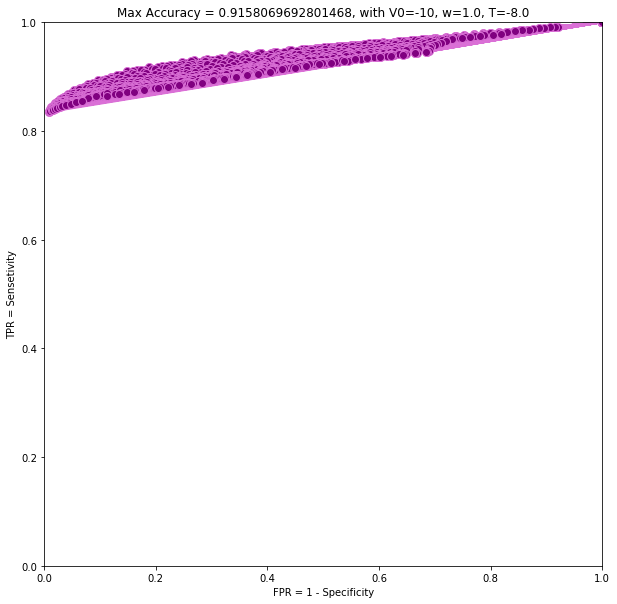

In [15]:
## ROC curve (Receiver Operating Characteristic)

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

i = 0


    
Sensetivity_list = list(Combination_wise_table['Mean_Sensetivity'])
Specificity_list = list(Combination_wise_table['Mean_Specificity'])
Accuracy_list = list(Combination_wise_table['Mean_Accuracy'])

max_accuracy = max(Accuracy_list)
max_index = Accuracy_list.index(max_accuracy)
comcom = combinations[max_index]

FPR = list(np.ones(len(Specificity_list)) - Specificity_list)

ax.plot(list(FPR), Sensetivity_list, color="orchid", lw=2, ls='-', marker='o', markersize=8, markerfacecolor="purple")

ax.set_xlabel('FPR = 1 - Specificity')
ax.set_ylabel('TPR = Sensetivity')

ax.set_title('Max Accuracy = {}, with {}'.format(max_accuracy, comcom))

i = 0

ax.set_ylim([0,1])
ax.set_xlim([0,1])

#for label, x, y in zip(Combination_wise_table['Combinations'], list(FPR), Sensetivity_list):
#    ax.annotate(
#        label,
#        xy=(x, y), xytext=(-15, 15),
#        textcoords='offset points', ha='right', va='bottom',
#        bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=1),
#        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))        


## Results:

#### Max Accuracy

In [ ]:
Combination_wise_table[Combination_wise_table.Mean_Accuracy == np.max(Combination_wise_table.Mean_Accuracy)]

#### Max Sensetivity

In [ ]:
Combination_wise_table[Combination_wise_table.Mean_Sensetivity == np.max(Combination_wise_table.Mean_Sensetivity)]

#### Max Sensetivity (less than 1)

In [ ]:
comcom = Combination_wise_table[Combination_wise_table.Mean_Sensetivity < 1]
comcom[comcom.Mean_Sensetivity == np.max(comcom.Mean_Sensetivity)]

#### Max Specificity

In [ ]:
Combination_wise_table[Combination_wise_table.Mean_Specificity == np.max(Combination_wise_table.Mean_Specificity)]

## Wanna see them?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

#Plot Data
fig, ax = plt.subplots(figsize = (8,8))
sns.distplot(Combination_wise_table.Mean_Accuracy, bins=25, color="y", ax=ax )
ax.set(xlabel="The distribution of accuracy", ylabel = "")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

#Plot Data
fig, ax = plt.subplots(figsize = (8,8))
sns.distplot(Combination_wise_table.Mean_Sensetivity, bins=25, color="orange", ax=ax )
ax.set(xlabel="The distribution of sensetivity", ylabel = "")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd

#Plot Data
fig, ax = plt.subplots(figsize = (8,8))
sns.distplot(Combination_wise_table.Mean_Specificity, bins=25, color="red", ax=ax )
ax.set(xlabel="The distribution of specificity", ylabel = "")
plt.show()

### Best point (sens and spec more than 0.8)

In [ ]:
Combination_wise_table[(Combination_wise_table.Mean_Sensetivity >= 0.89) & (Combination_wise_table.Mean_Specificity >= 0.89) & (Combination_wise_table.Mean_Accuracy >= 0.88)]

### For further information please contact rzz5164@psu.edu